In [1]:
%matplotlib inline

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.linear_model import LogisticRegression, RANSACRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

from sklearn.metrics import f1_score, make_scorer, classification_report

# Sumo Matches Forecast

1. Explore data.
1. Model data.
    - prepare data
    - extract the latest 2 tournaments to use as test
    - select a subset of predictors from all features
        - with "delta" features or without them
    - prepare folds
    - prepare scorer
    - model selection
    - test the model on a subset of the original data - only recent bouts (from 2000) 

## Model data

### Get data ready for modeling

1. Read.
1. Separate the output (label) variable `bout_outcome1`.
1. Select a subset of predictor (attribute) columns.
1. Scale the 

In [55]:
sumo = pd.read_csv("cleaned_sumo.csv")

In [56]:
# Test. TODO move to EDA section.
assert sumo.isna().sum().sum() == 0

### Features set #1

In [57]:
bout_outcomes = sumo.bout_outcome1

In [58]:
# Test. TODO move to EDA section.
assert bout_outcomes.nunique() == 2

In [59]:
# Select features
features_for_modeling = [
    # Wrestler 1 features
    ## Characteristics
    'age1',
    'height1',
    'weight1',
    'bmi1',
    'rank1',
    
    ## Performance
    'career_bouts1',
    'career_win_percentage1',
  
    'tournament_win_percentage1',
    'tournament_win_rolling1',
    
    'previous_tournament_win_percentage1',
    'previous_tournament_bouts1',
    
    # Delta features
    ## Characteristics
    'age_delta',
    'bmi_delta',
    'height_delta',
    'weight_delta',
    'rank_delta',

    ## Performance
    'career_bouts_delta',
    'career_win_percentage_delta',
  
    'previous_tournament_win_percentage_delta',
    'previous_tournament_bouts_delta',
    
    'tournament_win_percentage_delta',
    'tournament_win_rolling_delta',
]

# Transform data
features_transformer = make_column_transformer(
    (MinMaxScaler(), features_for_modeling),
    remainder='drop',
)
sumo_attributes_transformed = features_transformer.fit_transform(sumo)

# Split data
attributes_train, attributes_test, labels_train, labels_test = train_test_split(
    sumo_attributes_transformed, bout_outcomes, test_size=10_000, stratify=bout_outcomes)

for data_set in [attributes_train, attributes_test, labels_train, labels_test]:
    print(data_set.shape)

(119600, 22)
(10000, 22)
(119600,)
(10000,)


#### Logistic regression

In [8]:
# Helper function
def print_classification_report(model):
    # For training data
    report = classification_report(
        y_true=labels_train,
        y_pred=model.predict(attributes_train),
    )
    print("Classification report, training data\n\n", report)

    # For test data
    report = classification_report(
        y_true=labels_test,
        y_pred=model.predict(attributes_test),
    )
    print("Classification report, test data\n\n", report)

##### Fit and classification report

In [9]:
# Fit model
logistic_regression = LogisticRegression()
logistic_regression.fit(attributes_train, labels_train)

# Print reports
print_classification_report(logistic_regression)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report, training data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     59800
           1       0.59      0.59      0.59     59800

    accuracy                           0.59    119600
   macro avg       0.59      0.59      0.59    119600
weighted avg       0.59      0.59      0.59    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59      5000
           1       0.59      0.59      0.59      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



##### Weight coefficients

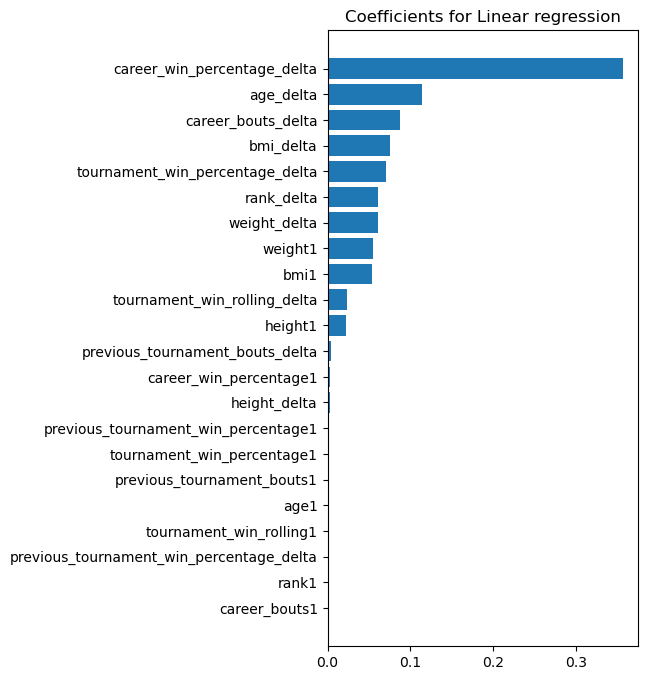

In [10]:
# Intepret model weight coefficients

weights = pd.Series(
    data=logistic_regression.coef_[0],
    index=features_for_modeling,
)
weights_abs = np.abs(weights)
weights_abs = weights_abs.sort_values()

plt.figure(figsize=(4, 8))
plt.barh(
    y=weights_abs.index, 
    width=weights_abs.values / weights_abs.sum(),
)
plt.title("Coefficients for Linear regression")
plt.show()

In [11]:
# LogisticRegression().get_params()

In [12]:
# Optimize - do grid search
params = {
    "C": [0.001, 1, 100, 10e4, 10e6],
    "penalty": ["l1", "l2", "elasticnet"],
    "max_iter": [200, 500],
}
grid_search = GridSearchCV(LogisticRegression(), params, cv = 3, scoring="f1")
grid_search.fit(attributes_train, labels_train)

# Print results
print("Best params: ", grid_search.best_params_)
print_classification_report(grid_search.best_estimator_)
grid_search.best_estimator_

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best params:  {'C': 10000000.0, 'max_iter': 200, 'penalty': 'l2'}
Classification report, training data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     59800
           1       0.59      0.59      0.59     59800

    accuracy                           0.59    119600
   macro avg       0.59      0.59      0.59    119600
weighted avg       0.59      0.59      0.59    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59      5000
           1       0.59      0.59      0.59      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.59     10000
weighted avg       0.59      0.59      0.59     10000



LogisticRegression(C=10000000.0, max_iter=200)

In [144]:
# grid_search.cv_results_.keys()

### Features set #2

In [15]:
# Select columns
features_for_modeling2 = [
    # Wrestler 1
    'age1',
    'bmi1',
    'height1',
    'previous_tournament_losses1',
    'previous_tournament_wins1',
    'rank1',
    'tournament_losses1',
    'tournament_wins1',
    'weight1',
    
    'career_wins1',
    'career_bouts1',
    'career_win_percentage1',
    'tournament_bouts1',
    'tournament_win_percentage1',
    'tournament_win_rolling1',
    'previous_tournament_win_percentage1',
    'previous_tournament_bouts1',

    # Wrestler 2
    'age2',
    'bmi2',
    'height2',
    'previous_tournament_losses2',
    'previous_tournament_wins2',
    'rank2',
    'tournament_losses2',
    'tournament_wins2',
    'weight2',

    'career_wins2',
    'career_bouts2',
    'career_win_percentage2',
    'tournament_bouts2',
    'tournament_win_percentage2',
    'tournament_win_rolling2',
    'previous_tournament_win_percentage2',
    'previous_tournament_bouts2',
]

# Transform data
features_transformer2 = make_column_transformer(
    (MinMaxScaler(), features_for_modeling2),
    remainder='drop',
)
sumo_attributes_transformed2 = features_transformer2.fit_transform(sumo)

# Split data
attributes_train2, attributes_test2, labels_train2, labels_test2 = train_test_split(
    sumo_attributes_transformed2, bout_outcomes, test_size=10_000, stratify=bout_outcomes)

for data_set in [attributes_train2, attributes_test2, labels_train2, labels_test2]:
    print(data_set.shape)

(119600, 34)
(10000, 34)
(119600,)
(10000,)


#### Logistic regression

In [17]:
# Helper function
def print_classification_report2(model):
    # For training data
    report = classification_report(
        y_true=labels_train,
        y_pred=model.predict(attributes_train2),
    )
    print("Classification report, training data\n\n", report)

    # For test data
    report = classification_report(
        y_true=labels_test,
        y_pred=model.predict(attributes_test2),
    )
    print("Classification report, test data\n\n", report)

In [18]:
# Fit model
logistic_regression2 = LogisticRegression()
logistic_regression2.fit(attributes_train2, labels_train2)

# Print reports
print_classification_report2(logistic_regression2)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report, training data

               precision    recall  f1-score   support

           0       0.50      0.50      0.50     59800
           1       0.50      0.50      0.50     59800

    accuracy                           0.50    119600
   macro avg       0.50      0.50      0.50    119600
weighted avg       0.50      0.50      0.50    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.50      0.51      0.50      5000
           1       0.50      0.50      0.50      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



In [19]:
# Optimize - do grid search
params = {
    "C": [0.001, 1, 100, 10e4, 10e6],
    "penalty": ["l1", "l2", "elasticnet"],
    "max_iter": [200, 500],
}
grid_search = GridSearchCV(LogisticRegression(), params, cv = 3, scoring="f1")
grid_search.fit(attributes_train2, labels_train2)

# Print results
print("Best params: ", grid_search.best_params_)
print_classification_report(grid_search.best_estimator_)
grid_search.best_estimator_

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best params:  {'C': 10000000.0, 'max_iter': 500, 'penalty': 'l2'}


ValueError: X has 22 features, but LogisticRegression is expecting 34 features as input.

In [21]:
print_classification_report2(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.50      0.50      0.50     59800
           1       0.50      0.50      0.50     59800

    accuracy                           0.50    119600
   macro avg       0.50      0.50      0.50    119600
weighted avg       0.50      0.50      0.50    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.50      0.50      0.50      5000
           1       0.50      0.50      0.50      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



### RANSAC

In [120]:
ransac = RANSACRegressor(
    estimator=LogisticRegression(),
    min_samples=30,
)

In [121]:
ransac.fit(attributes_train, labels_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RANSACRegressor(estimator=LogisticRegression(), min_samples=30)

In [122]:
print_classification_report(ransac.estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.55      0.71      0.62     59800
           1       0.59      0.43      0.50     59800

    accuracy                           0.57    119600
   macro avg       0.57      0.57      0.56    119600
weighted avg       0.57      0.57      0.56    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.55      0.69      0.61      5000
           1       0.58      0.43      0.50      5000

    accuracy                           0.56     10000
   macro avg       0.57      0.56      0.56     10000
weighted avg       0.57      0.56      0.56     10000



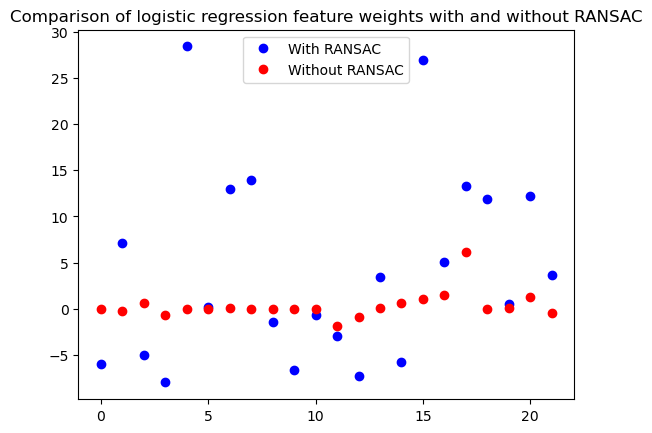

In [123]:
ransac_coef = ransac.estimator_.coef_.ravel()
linreg_coef = logistic_regression.coef_.ravel()

plt.plot(range(len(ransac_coef)), ransac_coef, 'bo', label='With RANSAC')
plt.plot(range(len(linreg_coef)), linreg_coef, 'ro', label='Without RANSAC')

plt.title("Comparison of logistic regression feature weights with and without RANSAC")
plt.legend()
plt.show()

In [131]:
# Logistic regression accuracy, all records (without RANSAC)
logistic_regression_accuracy = logistic_regression.score(attributes_train, labels_train)

# Logistic regression accuracy, outliers removed (with RANSAC)
ransac_accuracy = ransac.score(attributes_train, labels_train)

# RANSAC inliers score
attributes_train_inliers = attributes_train[ransac.inlier_mask_]
labels_train_inliers = labels_train[ransac.inlier_mask_]
ransac_inlier_accuracy = ransac.estimator_.score(attributes_train_inliers, labels_train_inliers)

# RANSAC outliers score
attributes_train_outliers = attributes_train[~ransac.inlier_mask_]
labels_train_outliers = labels_train[~ransac.inlier_mask_]
ransac_outlier_accuracy = ransac.estimator_.score(attributes_train_outliers, labels_train_outliers)

print(
    "R_squared Comparison Training Data",
    "-" * 30,
    f"Without RANSAC: {logistic_regression_accuracy:.2f}",
    f"With RANSAC, all points: {ransac_accuracy:.2f}",
    f"With RANSAC, inliers only: {ransac_inlier_accuracy:.2f}",
    f"With RANSAC, outliers only: {ransac_outlier_accuracy:.2f}",
    sep="\n",
)

print(f"\nInliers count: {len(attributes_train_inliers)}")
print(f"Outliers count: {len(attributes_train_outliers)}")

R_squared Comparison Training Data
------------------------------
Without RANSAC: 0.59
With RANSAC, all points: 0.57
With RANSAC, inliers only: 1.00
With RANSAC, outliers only: 0.01

Inliers count: 67855
Outliers count: 51745


### Polynomial features

In [112]:
features_transformer_poly = make_column_transformer(
    (MinMaxScaler(), features_for_modeling),
    (PolynomialFeatures(degree=2), features_for_modeling),
    remainder='drop',
)

In [113]:
sumo_attributes_transformed = features_transformer_poly.fit_transform(sumo)
sumo_attributes_transformed.shape

(129600, 298)

In [114]:
attributes_train, attributes_test, labels_train, labels_test = train_test_split(
    sumo_attributes_transformed, bout_outcomes, test_size=0.2, stratify=bout_outcomes)

for data_set in [attributes_train, attributes_test, labels_train, labels_test]:
    print(data_set.shape)

(103680, 298)
(25920, 298)
(103680,)
(25920,)


In [115]:
logistic_regression = LogisticRegression()
logistic_regression.fit(attributes_train, labels_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [116]:
print_classification_report(logistic_regression)

Classification report, training data

               precision    recall  f1-score   support

           0       0.57      0.60      0.59     51840
           1       0.58      0.55      0.57     51840

    accuracy                           0.58    103680
   macro avg       0.58      0.58      0.58    103680
weighted avg       0.58      0.58      0.58    103680

Classification report, test data

               precision    recall  f1-score   support

           0       0.57      0.60      0.58     12960
           1       0.58      0.54      0.56     12960

    accuracy                           0.57     25920
   macro avg       0.57      0.57      0.57     25920
weighted avg       0.57      0.57      0.57     25920



In [23]:
k_fold = StratifiedKFold(n_splits=5)
f1_scorer = make_scorer(f1_score, pos_label=1)

param_grid = {
    "max_depth": [1, 5, 7, 15, 20],
    "min_samples_leaf": [2, 5, 10, 12],
    "max_leaf_nodes": [5, 10, 20],
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=k_fold,
)

grid_search.fit(attributes_train, labels_train)

tree_classifier = grid_search.best_estimator_
print("Decision tree; best score:", grid_search.best_score_)

KeyboardInterrupt: 

In [25]:
param_grid = {
    # "C": [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20],
    "C": [0.1, 1, 20],
}

grid_search = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=k_fold,
)

grid_search.fit(attributes_train, labels_train)

linear_svm_classifier = grid_search.best_estimator_
print("Linear SVM; best score:", grid_search.best_score_)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM; best score: 0.5931148743732745


In [45]:
k_fold = StratifiedKFold(n_splits=3)

param_grid = {
    "n_estimators": [20, ],
    "max_depth": [50, 100],
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=k_fold,
)

grid_search.fit(attributes_train, labels_train)

random_forest = grid_search.best_estimator_
print("Random Forest; best score:", grid_search.best_score_)

Random Forest; best score: 0.5568443112009226


### Random forest

In [24]:
rf = RandomForestClassifier(n_estimators=20)
rf.fit(attributes_train, labels_train)

RandomForestClassifier(n_estimators=20)

In [25]:
print_classification_report(rf)

Classification report, training data

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     59800
           1       1.00      1.00      1.00     59800

    accuracy                           1.00    119600
   macro avg       1.00      1.00      1.00    119600
weighted avg       1.00      1.00      1.00    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.58      0.65      0.61      5000
           1       0.60      0.52      0.56      5000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.58     10000
weighted avg       0.59      0.59      0.58     10000



In [26]:
rf.n_outputs_

1

#### Optimize

In [27]:
params = {
    "n_estimators": [30, 50, 100],
    "max_depth": [5, 10],
    "min_samples_leaf": [10, 30],
}
grid_search = GridSearchCV(RandomForestClassifier(), params, cv = 3)

In [28]:
grid_search.fit(attributes_train, labels_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [10, 30],
                         'n_estimators': [30, 50]})

In [29]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_estimators=50)

In [30]:
print_classification_report(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.65      0.67      0.66     59800
           1       0.66      0.64      0.65     59800

    accuracy                           0.65    119600
   macro avg       0.65      0.65      0.65    119600
weighted avg       0.65      0.65      0.65    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.61      0.62      0.61      5000
           1       0.61      0.60      0.60      5000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



#### Optimize - iteration 2

In [31]:
params = {
    "n_estimators": [30, 50, 60],
    "max_depth": [10, 20],
    "min_samples_leaf": [5, 10],
}
grid_search = GridSearchCV(RandomForestClassifier(), params, cv = 3)

In [32]:
grid_search.fit(attributes_train, labels_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [5, 10],
                         'n_estimators': [30, 50, 60]})

In [33]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=60)

In [34]:
print_classification_report(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.86      0.87      0.86     59800
           1       0.87      0.86      0.86     59800

    accuracy                           0.86    119600
   macro avg       0.86      0.86      0.86    119600
weighted avg       0.86      0.86      0.86    119600

Classification report, test data

               precision    recall  f1-score   support

           0       0.61      0.63      0.62      5000
           1       0.62      0.60      0.61      5000

    accuracy                           0.61     10000
   macro avg       0.61      0.61      0.61     10000
weighted avg       0.61      0.61      0.61     10000



### Use recent data

In [37]:
sumo_from_2000 = sumo[sumo.year >= 2000]
bout_outcomes = sumo_from_2000.bout_outcome1

# Select features
features_for_modeling = [
    # Wrestler 1 features
    ## Characteristics
    'age1',
    'height1',
    'weight1',
    'bmi1',
    'rank1',
    
    ## Performance
    'career_bouts1',
    'career_win_percentage1',
  
    'tournament_win_percentage1',
    'tournament_win_rolling1',
    
    'previous_tournament_win_percentage1',
    'previous_tournament_bouts1',
    
    # Delta features
    ## Characteristics
    'age_delta',
    'bmi_delta',
    'height_delta',
    'weight_delta',
    'rank_delta',

    ## Performance
    'career_bouts_delta',
    'career_win_percentage_delta',
  
    'previous_tournament_win_percentage_delta',
    'previous_tournament_bouts_delta',
    
    'tournament_win_percentage_delta',
    'tournament_win_rolling_delta',
]

# Transform data
features_transformer = make_column_transformer(
    (MinMaxScaler(), features_for_modeling),
    remainder='drop',
)
sumo_attributes_transformed = features_transformer.fit_transform(sumo_from_2000)

# Split data
attributes_train, attributes_test, labels_train, labels_test = train_test_split(
    sumo_attributes_transformed, bout_outcomes, test_size=5_000, stratify=bout_outcomes)

for data_set in [attributes_train, attributes_test, labels_train, labels_test]:
    print(data_set.shape)

(70724, 22)
(5000, 22)
(70724,)
(5000,)


#### Logistic regression

In [38]:
# Helper function
def print_classification_report(model):
    # For training data
    report = classification_report(
        y_true=labels_train,
        y_pred=model.predict(attributes_train),
    )
    print("Classification report, training data\n\n", report)

    # For test data
    report = classification_report(
        y_true=labels_test,
        y_pred=model.predict(attributes_test),
    )
    print("Classification report, test data\n\n", report)

##### Fit and classification report

In [39]:
# Fit model
logistic_regression = LogisticRegression()
logistic_regression.fit(attributes_train, labels_train)

# Print reports
print_classification_report(logistic_regression)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report, training data

               precision    recall  f1-score   support

           0       0.60      0.60      0.60     35362
           1       0.60      0.60      0.60     35362

    accuracy                           0.60     70724
   macro avg       0.60      0.60      0.60     70724
weighted avg       0.60      0.60      0.60     70724

Classification report, test data

               precision    recall  f1-score   support

           0       0.61      0.62      0.61      2500
           1       0.61      0.60      0.60      2500

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



##### Weight coefficients

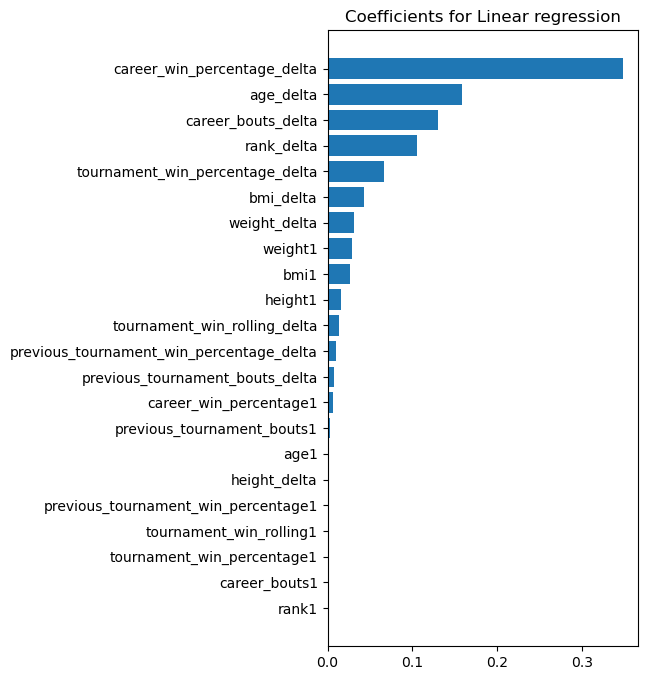

In [40]:
# Intepret model weight coefficients

weights = pd.Series(
    data=logistic_regression.coef_[0],
    index=features_for_modeling,
)
weights_abs = np.abs(weights)
weights_abs = weights_abs.sort_values()

plt.figure(figsize=(4, 8))
plt.barh(
    y=weights_abs.index, 
    width=weights_abs.values / weights_abs.sum(),
)
plt.title("Coefficients for Linear regression")
plt.show()

In [11]:
# LogisticRegression().get_params()

In [41]:
# Optimize - do grid search
params = {
    "C": [0.001, 1, 100, 10e4, 10e6],
    "penalty": ["l1", "l2", "elasticnet"],
    "max_iter": [200, 500],
}
grid_search = GridSearchCV(LogisticRegression(), params, cv = 3, scoring="f1")
grid_search.fit(attributes_train, labels_train)

# Print results
print("Best params: ", grid_search.best_params_)
print_classification_report(grid_search.best_estimator_)
grid_search.best_estimator_

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

Best params:  {'C': 10000000.0, 'max_iter': 200, 'penalty': 'l2'}
Classification report, training data

               precision    recall  f1-score   support

           0       0.60      0.60      0.60     35362
           1       0.60      0.60      0.60     35362

    accuracy                           0.60     70724
   macro avg       0.60      0.60      0.60     70724
weighted avg       0.60      0.60      0.60     70724

Classification report, test data

               precision    recall  f1-score   support

           0       0.61      0.62      0.62      2500
           1       0.61      0.60      0.61      2500

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



LogisticRegression(C=10000000.0, max_iter=200)

In [42]:
print_classification_report(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.60      0.60      0.60     35362
           1       0.60      0.60      0.60     35362

    accuracy                           0.60     70724
   macro avg       0.60      0.60      0.60     70724
weighted avg       0.60      0.60      0.60     70724

Classification report, test data

               precision    recall  f1-score   support

           0       0.61      0.62      0.62      2500
           1       0.61      0.60      0.61      2500

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



#### Random Forest

In [44]:
k_fold = StratifiedKFold(n_splits=4)
f1_scorer = make_scorer(f1_score, pos_label=1)
params = {
    "n_estimators": [30, 50, 60],
    "max_depth": [10, 20],
    "min_samples_leaf": [5, 10],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=params, 
    cv=k_fold,
    scoring=f1_scorer,
)



grid_search.fit(attributes_train, labels_train)

print_classification_report(grid_search.best_estimator_)

grid_search.best_estimator_

Classification report, training data

               precision    recall  f1-score   support

           0       0.67      0.68      0.67     35362
           1       0.67      0.66      0.67     35362

    accuracy                           0.67     70724
   macro avg       0.67      0.67      0.67     70724
weighted avg       0.67      0.67      0.67     70724

Classification report, test data

               precision    recall  f1-score   support

           0       0.60      0.62      0.61      2500
           1       0.61      0.59      0.60      2500

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=60)

### Predict last three tournaments

In [48]:
may_2022 = sumo[(sumo.year == 2022) & (sumo.month == 5)]
july_2022 = sumo[(sumo.year == 2022) & (sumo.month == 7)]
september_2022 = sumo[(sumo.year == 2022) & (sumo.month == 9)]

scaler = MinMaxScaler()
attributes_data = sumo[(sumo.year == 2022) & ~(sumo.month.isin([5, 7, 9]))]
attributes_train = scaler.fit_transform(attributes_data)
labels_train = attributes_data.bout_outcome1

### Linear SVC

In [125]:
svc = LinearSVC()
svc.fit(attributes_train, labels_train)

LinearSVC()

In [126]:
print_classification_report(svc)

Classification report, training data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     51840
           1       0.59      0.59      0.59     51840

    accuracy                           0.59    103680
   macro avg       0.59      0.59      0.59    103680
weighted avg       0.59      0.59      0.59    103680

Classification report, test data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     12960
           1       0.59      0.60      0.59     12960

    accuracy                           0.59     25920
   macro avg       0.59      0.59      0.59     25920
weighted avg       0.59      0.59      0.59     25920



#### Optimize

In [147]:
params = {
    "C": [0.1, 1, 10],
}

grid_search = GridSearchCV(
    estimator=LinearSVC(),
    param_grid=params,
    cv=3,
)

In [148]:
grid_search.fit(attributes_train, labels_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(), param_grid={'C': [0.1, 1, 10]})

In [149]:
print_classification_report(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     51840
           1       0.59      0.59      0.59     51840

    accuracy                           0.59    103680
   macro avg       0.59      0.59      0.59    103680
weighted avg       0.59      0.59      0.59    103680

Classification report, test data

               precision    recall  f1-score   support

           0       0.59      0.59      0.59     12960
           1       0.59      0.60      0.59     12960

    accuracy                           0.59     25920
   macro avg       0.59      0.59      0.59     25920
weighted avg       0.59      0.59      0.59     25920



### Gaussian SVC

In [60]:
k_fold = StratifiedKFold(n_splits=4)
f1_scorer = make_scorer(f1_score, pos_label=1)

param_grid = {
    "C": [10, 200],
    "gamma": [0.001, 0.2],
}

grid_search = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid=param_grid,
    cv=k_fold,
    scoring=f1_scorer,
)

In [ ]:
grid_search.fit(attributes_train, labels_train)

In [ ]:
grid_search.best_estimator_

In [ ]:
print_classification_report(grid_search.best_estimator_)

### AdaBoost

In [57]:
params = {
    "base_estimator": [DecisionTreeClassifier(), LogisticRegression()],
    "n_estimators": [5, 10, 100],
}

grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=params,
    cv=3,
)

In [58]:
grid_search.fit(attributes_train, labels_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'base_estimator': [DecisionTreeClassifier(),
                                            LogisticRegression()],
                         'n_estimators': [5, 10, 100]})

In [59]:
print_classification_report(grid_search.best_estimator_)

Classification report, training data

               precision    recall  f1-score   support

           0       0.57      0.61      0.59     51840
           1       0.58      0.54      0.56     51840

    accuracy                           0.57    103680
   macro avg       0.57      0.57      0.57    103680
weighted avg       0.57      0.57      0.57    103680

Classification report, test data

               precision    recall  f1-score   support

           0       0.57      0.61      0.59     12960
           1       0.58      0.54      0.56     12960

    accuracy                           0.57     25920
   macro avg       0.58      0.57      0.57     25920
weighted avg       0.58      0.57      0.57     25920



### PCA


In [60]:
pca = PCA()
pca.fit(attributes_train, labels_train)

PCA()

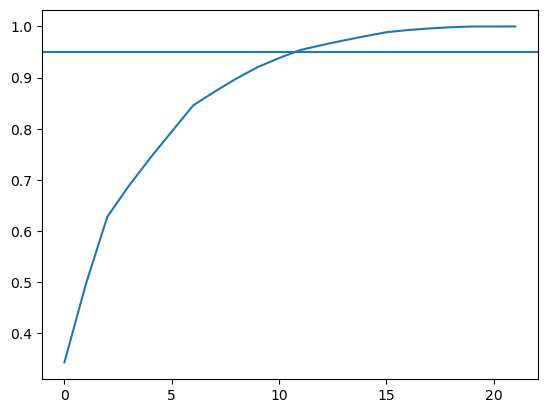

In [62]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(0.95)